# Task 2: Variational Autoencoder

Задача: обучить вариационный автоэнкодер на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

# Theory
VAE:
1. RU: https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/ 
2. ENG: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained

CVAE:
1. RU: https://habr.com/ru/post/331664/
2. ENG: https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8

In [1]:
from torchvision import datasets
from torchvision import transforms
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [3]:
hidden_dim=128

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=hidden_dim*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784)
        )

    def encode(self, x):
        # encoding
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, hidden_dim)
        # get `mu` and `logsigma`
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance5
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [4]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae
autoencoder = VAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [6]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        img_batch = batch[0]
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(img_batch.to(device))
        reconstruction = reconstruction.view(-1, 28, 28, 1)
        loss = criterion(img_batch.view(-1, 28, 28, 1).to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch[0].to(device))
          reconstruction = reconstruction.view(-1, 28, 28, 1)
          loss = criterion(batch[0].view(-1, 28, 28, 1).to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

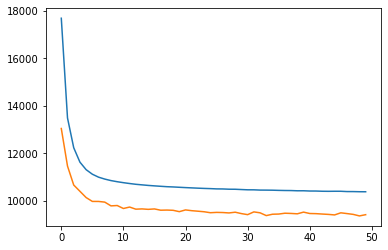

In [7]:
plt.plot(train_losses)
plt.plot(val_losses)

In [8]:
autoencoder.eval()
with torch.no_grad():
  for batch in test_loader:
    batch = batch[0]
    reconstruction, mu, logsigma = autoencoder(batch.to(device))
    reconstruction = reconstruction.view(-1, 28, 28, 1)
    result = reconstruction.cpu().detach().view(-1, 28, 28, 1).numpy()
    ground_truth = batch.view(-1, 28, 28, 1).numpy()
    break

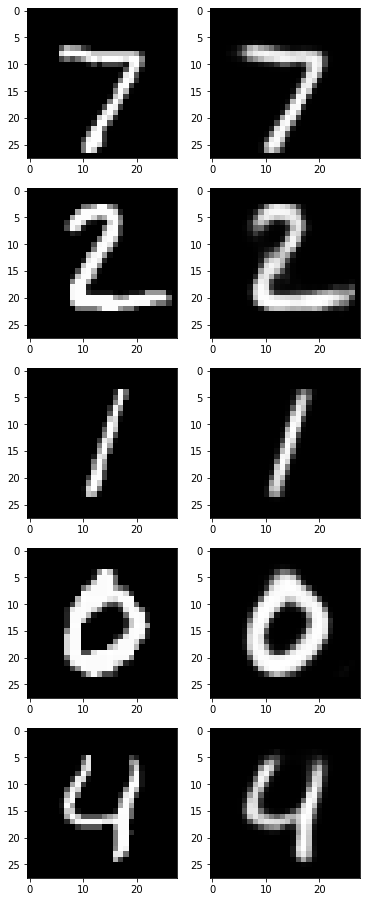

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 16))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt, cmap='gray')
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res, cmap='gray')

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

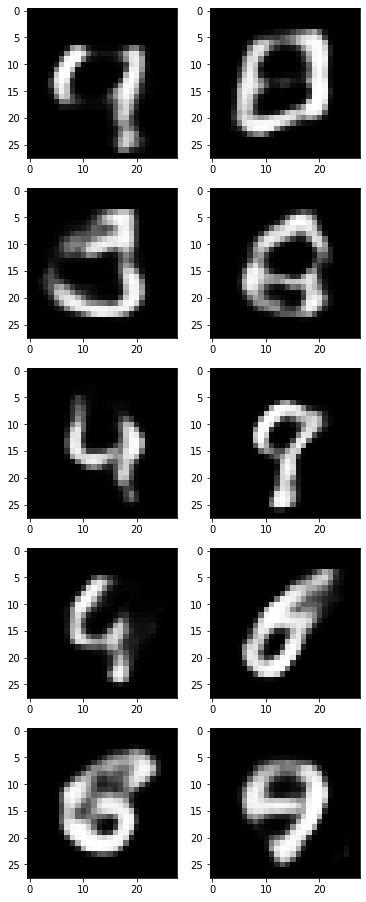

In [28]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, hidden_dim) for i in range(10)])
output = autoencoder.decode(torch.tensor(z).float().to(device)).view(-1, 28, 28, 1)

plt.figure(figsize=(6, 16))
for i in range(10):
     plt.subplot(5, 2, i+1)
     plt.imshow(output[i].cpu().detach().numpy(), cmap='gray')

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок цифр выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [11]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([test_dataset.data[test_dataset.targets==i]
               for i in range(10)]) / 255.
y = np.hstack([test_dataset.targets[test_dataset.targets==i]
               for i in range(10)])

#Get latent dimensions for images
X = torch.tensor(X).view(-1, 1, 28, 28)
autoencoder = autoencoder.to('cpu')
autoencoder.eval()
with torch.no_grad():
    X_encoded = autoencoder.encode(X)[0]
print(X_encoded.shape)

torch.Size([10000, 128])


In [12]:
from sklearn.manifold import TSNE

digits_proj = TSNE().fit_transform(X_encoded)

H:\Programs\Anaconda\envs\TF-Python9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
H:\Programs\Anaconda\envs\TF-Python9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
#Function to scatter X projections for corresponding digit
def scatter(x, colors):
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=colors)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

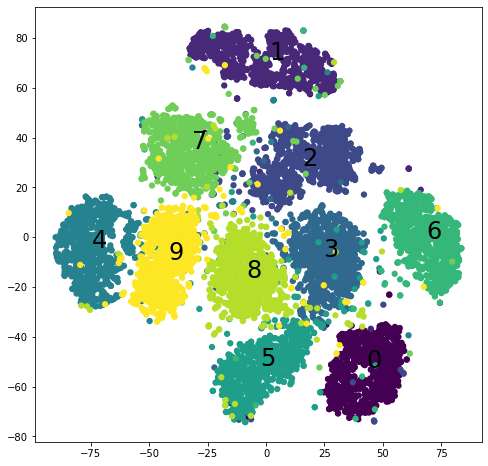

In [14]:
scatter(digits_proj, y);

Что вы думаете о виде латентного представления?

## 2.3. Conditional VAE


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [29]:
hidden_dim=128

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28*1+10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=hidden_dim*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=hidden_dim+10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784)
        )

    def encode(self, x):
        # encoding
        x = self.encoder(x).view(-1, 2, hidden_dim)
        # get `mu` and `logsigma`
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance5
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        # decoding
        x = self.decoder(torch.cat((z.view(-1, hidden_dim), class_num), dim=1))
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        x_cat = torch.cat((x, class_num), dim=1)
        mu, logsigma = self.encode(x_cat)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample, class_num)
        return reconstruction, mu, logsigma

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [30]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae
autoencoder = CVAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [31]:
#Functiom to get vectors of zeros with one for needed digit
def idx2onehot(idx, n=10):
    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n
    onehot = torch.zeros(idx.size(0), n, device=idx.device)
    onehot.scatter_(1, idx.data, 1)
    return onehot

In [32]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        img_batch = batch[0]
        target_batch = batch[1]
        
        optimizer.zero_grad()
        
        target_batch = idx2onehot(target_batch.view(-1, 1)).to(device)
        reconstruction, mu, logsigma = autoencoder(img_batch.view(-1, 28*28).to(device), target_batch)
        reconstruction = reconstruction.view(-1, 28, 28, 1)
        loss = criterion(img_batch.view(-1, 28, 28, 1).to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
            img_batch = batch[0]
            target_batch = batch[1]
            
            target_batch = idx2onehot(target_batch.view(-1, 1)).to(device)
            reconstruction, mu, logsigma = autoencoder(img_batch.view(-1, 28*28).to(device), target_batch)
            reconstruction = reconstruction.view(-1, 28, 28, 1)
            loss = criterion(batch[0].view(-1, 28, 28, 1).to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

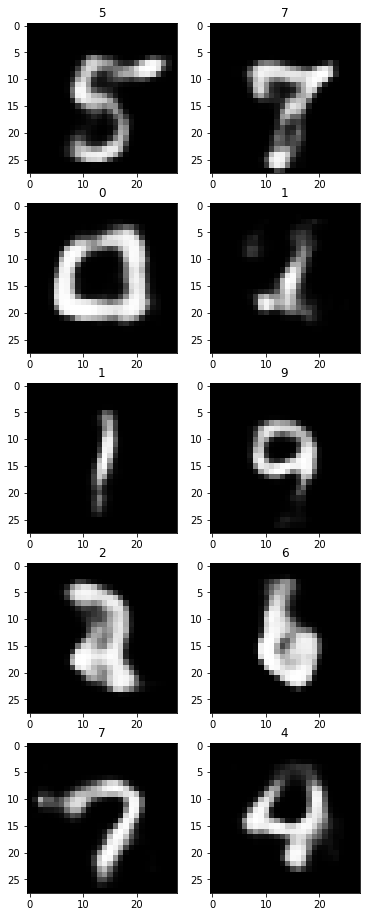

In [33]:
#here we try to get different digits from same latent vector
z = np.array([np.random.normal(0, 1, hidden_dim) for i in range(5)])
nums1 = torch.tensor([5, 0, 1, 2, 7]).to(device)
nums2 = torch.tensor([7, 1, 9, 6, 4]).to(device)
nums1_onehot = idx2onehot(nums1.view(-1, 1))
nums2_onehot = idx2onehot(nums2.view(-1, 1))
output1 = autoencoder.decode(torch.tensor(z).float().to(device), nums1_onehot).view(-1, 28, 28, 1).cpu().detach().numpy()
output2 = autoencoder.decode(torch.tensor(z).float().to(device), nums2_onehot).view(-1, 28, 28, 1).cpu().detach().numpy()

#For 5 different latent vectors get pair of 2 digits
plt.figure(figsize=(6, 16))
#fig, ax = plt.subplots(5, 2)
for i, (num1, num2) in enumerate(zip(output1, output2)):
  plt.subplot(5, 2, 2*i+1, title=f'{nums1[i]}')
  plt.imshow(num1, cmap='gray')
  plt.subplot(5, 2, 2*i+2, title=f'{nums2[i]}')
  plt.imshow(num2, cmap='gray')

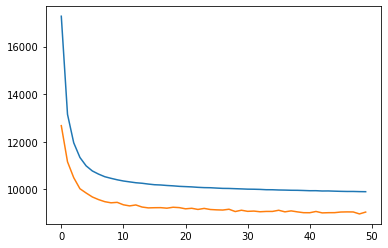

In [34]:
plt.plot(train_losses)
plt.plot(val_losses)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [35]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([test_dataset.data[test_dataset.targets==i]
               for i in range(10)]) / 255.
y = np.hstack([test_dataset.targets[test_dataset.targets==i]
               for i in range(10)])

#Get latent dimensions for images
X = torch.tensor(X).view(-1, 28*28).float()
autoencoder = autoencoder.to('cpu')
autoencoder.eval()
y_onehot = idx2onehot(torch.tensor(y).view(-1, 1))
with torch.no_grad():
    X_encoded = autoencoder.encode(torch.cat((X, y_onehot), dim=1))[0]
print(X_encoded.shape)

torch.Size([10000, 128])


In [36]:
from sklearn.manifold import TSNE

digits_proj = TSNE().fit_transform(X_encoded)

H:\Programs\Anaconda\envs\TF-Python9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
H:\Programs\Anaconda\envs\TF-Python9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


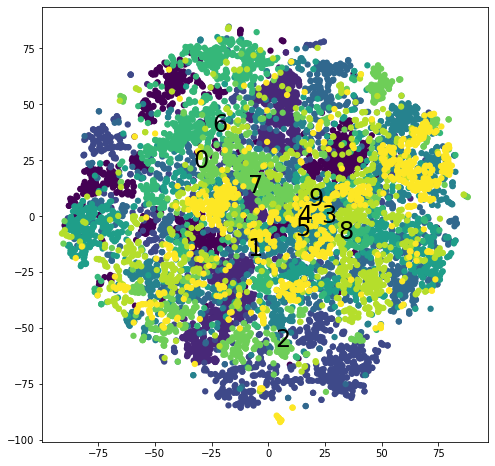

In [37]:
#Function to scatter X projections for corresponding digit
def scatter(x, colors):
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=colors)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    #ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

scatter(digits_proj, y);

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?